<span style="font-weight:bold; font-size: 3rem; color:#0047AB;">Inference Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Retrieves model and feature data from Hopsworks
2. Does inference based on new data
3. Saves prediction in new feature group to monitor predictions vs actual values
4. Prints predicitons vs. actual values


## <span style='color:#ff5f27'> Imports</span>

In [1]:
import pandas as pd
import os
import numpy as np
import requests
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import time
import json
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import openmeteo_requests
import requests_cache
from retry_requests import retry
import hsfs
from pathlib import Path
from dotenv import load_dotenv
import hopsworks
import sys
import time

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from format_data import format_weather_data, format_price_data, merge_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## <span style='color:#ff5f27'> Retrieve model and features from Hopsworks</span>

In [2]:
if not os.getenv("CI"): 
    load_dotenv()
    
hopsworks_api = os.getenv("HOPSWORKS_API_KEY")

if not hopsworks_api:
    raise ValueError("HOPSWORKS_API_KEY is not set.")

os.environ["HOPSWORKS_API_KEY"] = hopsworks_api

project = hopsworks.login()
fs = project.get_feature_store() 
print(f"Connected to project: {project.name}")

2025-01-09 11:44:18,573 INFO: Initializing external client
2025-01-09 11:44:18,576 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-09 11:44:20,145 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164446
Connected to project: oskaralf


### Get model

In [3]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="electricity_xgboost_model_se3",
    version=1,
)
saved_model_dir = retrieved_model.download()

In [4]:
saved_model_dir
retrieved_xgboost_model = xgb.XGBRegressor()
retrieved_xgboost_model.load_model(saved_model_dir + "/model_se3.json")
retrieved_xgboost_model

XGBRegressor(base_score='8.778864E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Get feature data

In [6]:
weather_fg = fs.get_feature_group(
    name='weather_data_3',
    version=1,
)
entsoe_fg = fs.get_feature_group(
    name='entsoe_data_3',
    version=1,
)
entsoe_fg = fs.get_feature_group(name='entsoe_data_3', version=1)
weather_fg = fs.get_feature_group(name='weather_data_3', version=1)

entsoe_df = entsoe_fg.read()
weather_df = weather_fg.read()

entsoe_df['date'] = pd.to_datetime(entsoe_df['date']).dt.tz_convert('UTC')
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.tz_convert('UTC')

last_date = entsoe_df['date'].max()
#print("Last date in the entsoe data:", last_date)


weather_data = weather_fg.filter((weather_fg['date'] >= last_date - pd.Timedelta(hours=1)) & 
                                 (weather_fg['date'] <= last_date + pd.Timedelta(hours=1))).read()


2025-01-09 11:47:38,776 ERROR: Peer oskaralf__oalfreds is not known. Please register client certificates first.. Detail: Python exception: FlyingDuckException. gRPC client debug context: UNKNOWN:Error received from peer ipv4:51.79.26.27:5005 {grpc_message:"Peer oskaralf__oalfreds is not known. Please register client certificates first.. Detail: Python exception: FlyingDuckException", grpc_status:2, created_time:"2025-01-09T11:47:38.775425+01:00"}. Client context: IOError: Server never sent a data message. Detail: Internal
Traceback (most recent call last):
  File "/Users/oskaralfredsson/anaconda3/envs/SML/lib/python3.11/site-packages/hsfs/core/arrow_flight_client.py", line 364, in afs_error_handler_wrapper
    return func(instance, *args, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/oskaralfredsson/anaconda3/envs/SML/lib/python3.11/site-packages/hsfs/core/arrow_flight_client.py", line 427, in read_query
    return self._get_dataset(
           ^^^^^^^^^^^^^^^^^^
  File "

In [7]:
print(weather_data)

                       date  temperature_2m  precipitation  wind_speed_100m  \
0 2025-01-09 11:00:00+00:00          0.0175            0.0         9.504273   
1 2025-01-09 10:00:00+00:00         -0.0825            0.0        12.783802   
2 2025-01-09 09:00:00+00:00          0.4675            0.0        15.307410   

   temperature_2m_lag  precipitation_lag  wind_speed_100m_lag  
0             -0.0825                0.0            12.783802  
1              0.4675                0.0            15.307410  
2              0.4175                0.0            16.548256  


In [8]:
batch_data = pd.merge(weather_data, entsoe_df, on='date', how='inner')

In [9]:
batch_data

,date,temperature_2m,precipitation,wind_speed_100m,temperature_2m_lag,precipitation_lag,wind_speed_100m_lag,prices,imported_energy,total_load,total_generation_se,prices_lag,imported_energy_lag,total_load_lag,total_generation_se_lag,future_price
0,2025-01-09 09:00:00+00:00,0.4675,0.0,15.30741,0.4175,0.0,16.548256,156.15,733.0,34540.0,1503.0,164.88,1181.0,34726.5,1383.0,NaN


Dropping columns that were used before but deemed not useful after validation steps...

In [10]:
batch_data = batch_data.drop(columns = ['precipitation', 'precipitation_lag', 'future_price'])


In [11]:
column_order = ['date', 'prices', 'imported_energy', 'total_load', 'total_generation_se',
       'prices_lag', 'imported_energy_lag', 'total_load_lag', 'total_generation_se_lag',
       'temperature_2m', 'wind_speed_100m', 'temperature_2m_lag', 'wind_speed_100m_lag']

batch_data = batch_data[column_order]

## <span style='color:#ff5f27'> Inference</span>

In [12]:
batch_data['predicted_electricity_price'] = retrieved_xgboost_model.predict(
    batch_data[['prices', 'imported_energy', 'total_load', 'total_generation_se',
       'prices_lag', 'imported_energy_lag', 'total_load_lag', 'total_generation_se_lag',
       'temperature_2m', 'wind_speed_100m', 'temperature_2m_lag', 'wind_speed_100m_lag']])
batch_data

,date,prices,imported_energy,total_load,total_generation_se,prices_lag,imported_energy_lag,total_load_lag,total_generation_se_lag,temperature_2m,wind_speed_100m,temperature_2m_lag,wind_speed_100m_lag,predicted_electricity_price
0,2025-01-09 09:00:00+00:00,156.15,733.0,34540.0,1503.0,164.88,1181.0,34726.5,1383.0,0.4675,15.30741,0.4175,16.548256,147.827194


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         1 non-null      datetime64[us, Etc/UTC]
 1   prices                       1 non-null      float64                
 2   imported_energy              1 non-null      float64                
 3   total_load                   1 non-null      float64                
 4   total_generation_se          1 non-null      float64                
 5   prices_lag                   1 non-null      float64                
 6   imported_energy_lag          1 non-null      float64                
 7   total_load_lag               1 non-null      float64                
 8   total_generation_se_lag      1 non-null      float64                
 9   temperature_2m               1 non-null      float32                
 10  wind_s

## <span style='color:#ff5f27'> Saving inference data for monitoring</span>

In [14]:
monitor_fg = fs.get_or_create_feature_group(
    name='electricity_prediction_fg',
    version=1,
    primary_key=['date'],
    description='Predicted electricity prices for SE3',
    event_time='date',
)

In [15]:
print(batch_data)

                       date  prices  imported_energy  total_load  \
0 2025-01-09 09:00:00+00:00  156.15            733.0     34540.0   

   total_generation_se  prices_lag  imported_energy_lag  total_load_lag  \
0               1503.0      164.88               1181.0         34726.5   

   total_generation_se_lag  temperature_2m  wind_speed_100m  \
0                   1383.0          0.4675         15.30741   

   temperature_2m_lag  wind_speed_100m_lag  predicted_electricity_price  
0              0.4175            16.548256                   147.827194  


Here we use "wait for job" to ensure that newly added data is not missed due to latency issues

In [16]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: electricity_prediction_fg_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1164446/jobs/named/electricity_prediction_fg_1_offline_fg_materialization/executions
2025-01-09 11:48:27,848 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-09 11:48:34,475 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-09 11:50:10,902 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-09 11:50:11,079 INFO: Waiting for log aggregation to finish.
2025-01-09 11:50:26,746 INFO: Execution finished successfully.


(Job('electricity_prediction_fg_1_offline_fg_materialization', 'SPARK'), None)

In [17]:
time.sleep(30)

In [18]:
plot_data = monitor_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (49.27s) 


### Making plot graphics

In [19]:
first = plot_data['predicted_electricity_price'].iloc[-1]
second = plot_data['predicted_electricity_price'].iloc[-2]
change = round((first - second) / second,4)

if change < 0:
    color = 'red'
else:
    color = 'lightblue'

## <span style='color:#ff5f27'> Plotting monitored data to compare next-hour predictions to actual values</span>

### logic for plot graphics

In [20]:

d = plot_data['date'].iloc[-1] + pd.Timedelta(hours=2)
hour = d.strftime('%H:%M')
plus_1 = d + pd.Timedelta(hours=1)
interval = plus_1.strftime('%H:%M')
if change < 0:
    text = f'Price is likely to decrease by {round(abs(change)*100, 2)}% from {hour}'
else:
    text = f'Price is likely to increase by {round(change*100, 2)}% from {hour}'
print(text)

Price is likely to decrease by 13.41% from 11:00


### Actual plot

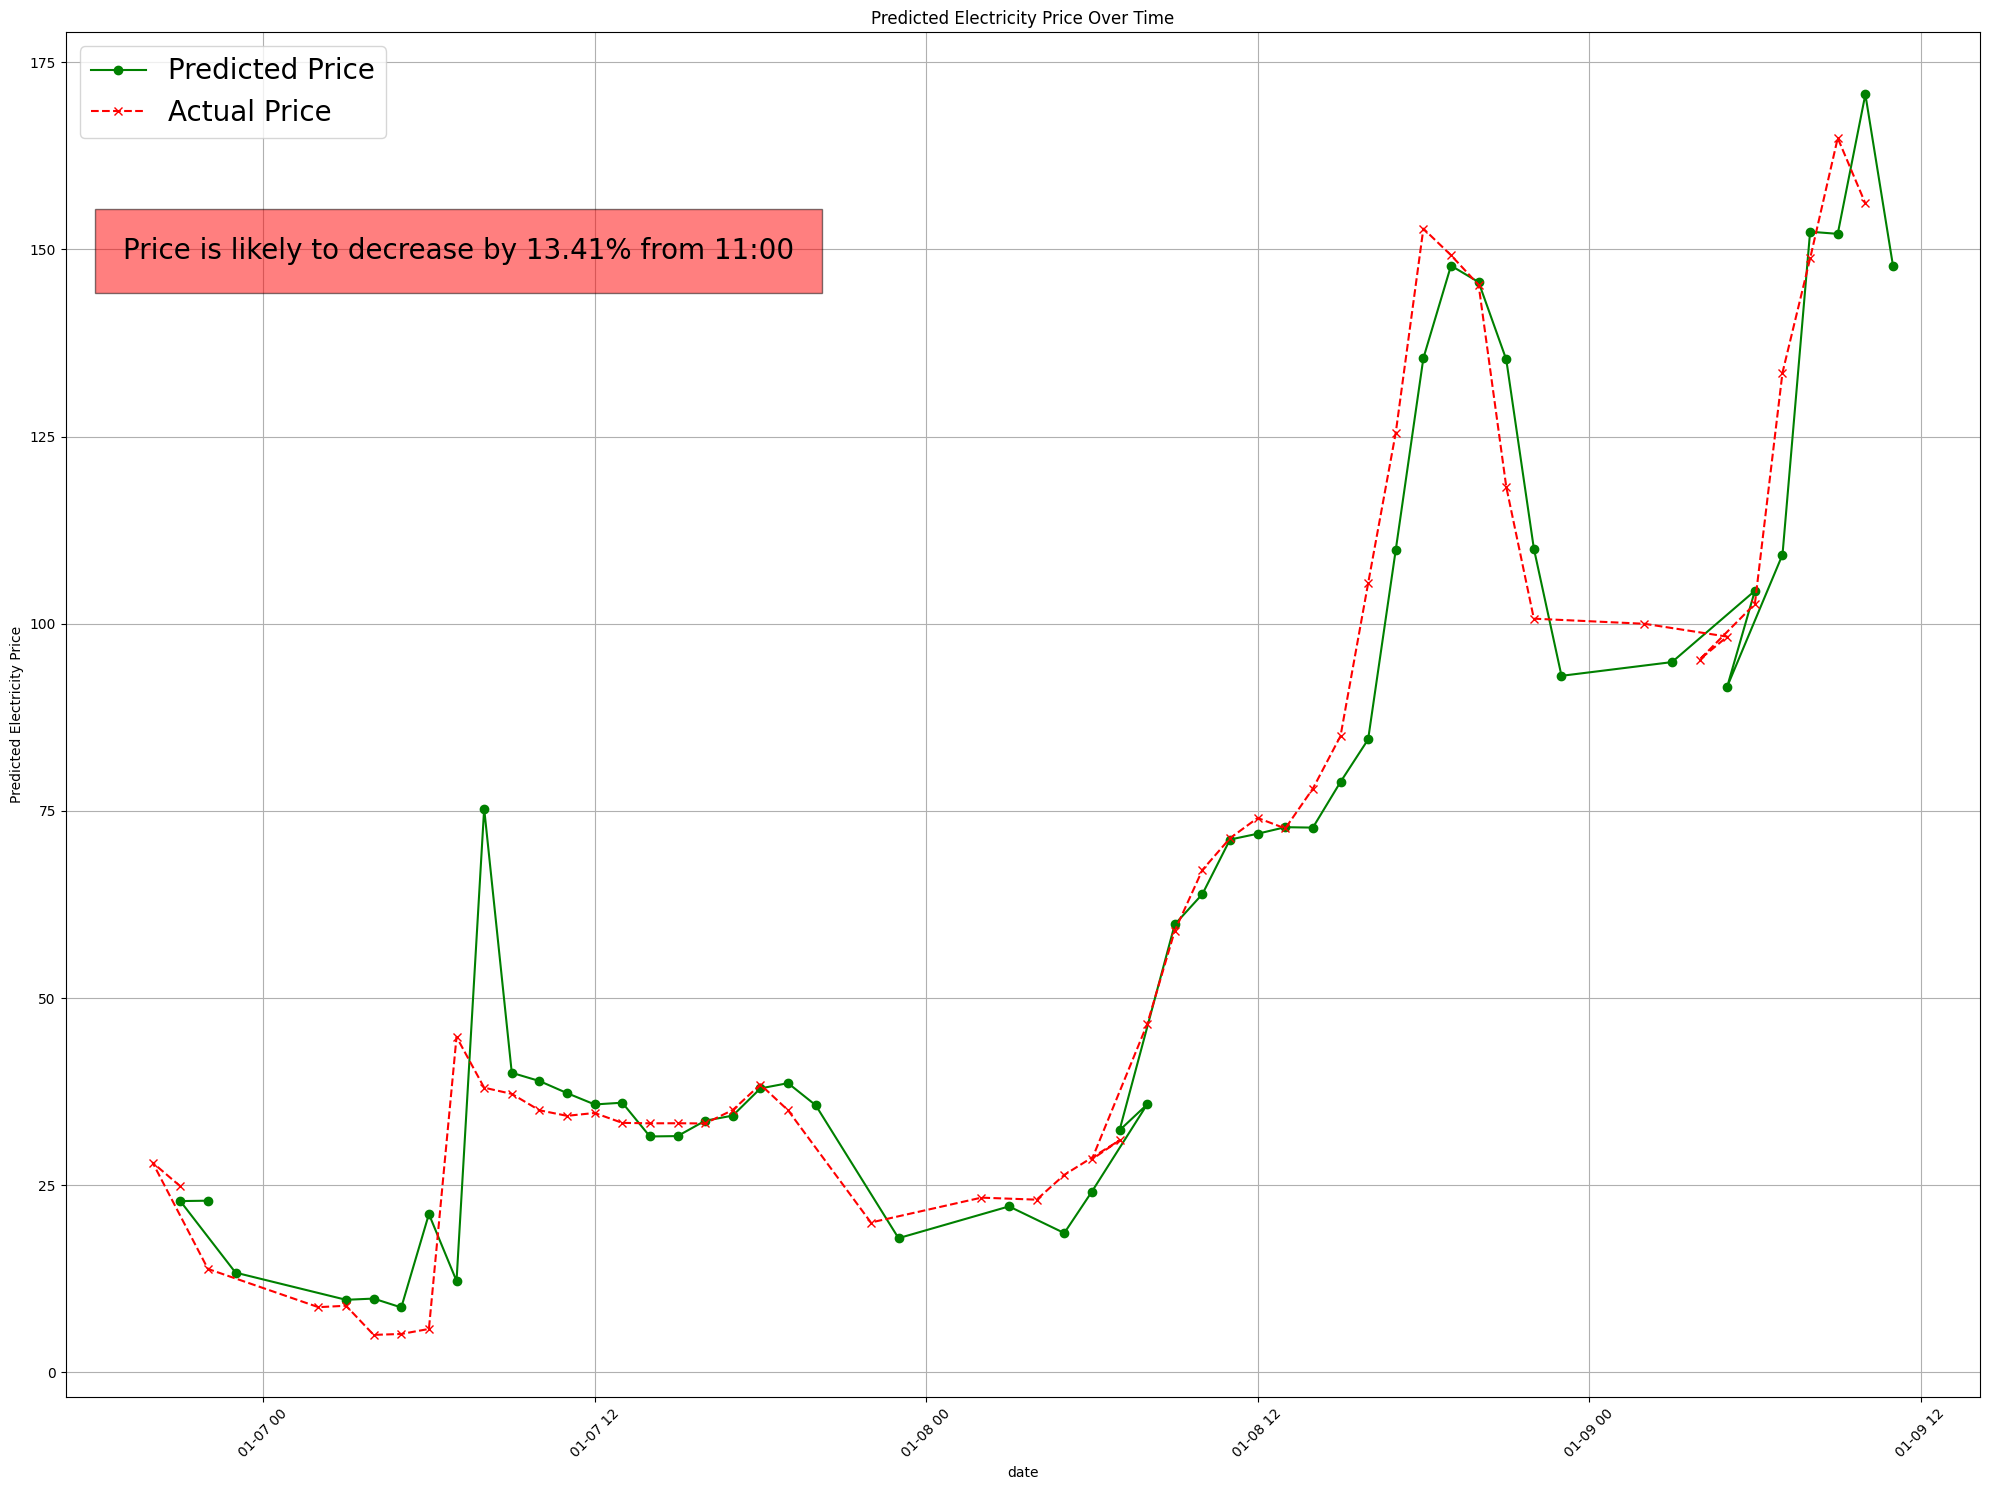

In [25]:

plt.figure(figsize=(20, 15))
plt.plot(plot_data['date']+pd.DateOffset(hours=2), plot_data['predicted_electricity_price'], marker='o', color='green', label='Predicted Price')
plt.plot(plot_data['date']+pd.DateOffset(hours=1), plot_data['prices'], marker='x', color='red', label='Actual Price', linestyle='--')


plt.xlabel('date')
plt.ylabel('Predicted Electricity Price')
plt.title('Predicted Electricity Price Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.legend(fontsize=20)

plt.gca().text(
    x=0.03, 
    y=0.85, 
    s=text, 
    fontsize=20,
    verticalalignment='top',
    horizontalalignment='left',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor=color, alpha=0.5, edgecolor='black', pad=20)
)

output_dir = 'Images/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'predicted_electricity_price_over_time_SE3.png')
plt.savefig(output_path)

plt.show()